In [2]:

import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
from sklearn.preprocessing import StandardScaler
import nibabel as nib
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 0) # this needs to be modified for some tasks
print('%i regions found in this atlas' % (len(np.unique(atlas_nii.get_data().ravel())) - 1))
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] # gives subject age on standard units after z-scoring

train_input = input_variables[:90]
train_output = output_variable[:90]
test_input = input_variables[90:]
test_output = output_variable[90:]

     |████████████████████████████████| 10.0 MB 25.8 MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)



Dataset created in /root/nilearn_data/oasis1



Downloaded 847708160 of 905208634 bytes (93.6%,    1.2s remaining) ...done. (19 seconds, 0 min)
Extracting data from /root/nilearn_data/oasis1/adcb228c7b26ed4f4fba93bd32bf8d97/archive_dartel.tgz..... done.
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
 ...done. (0 seconds, 0 min)
Extracting data from /root/nilearn_data/craddock_2012/45a4e574a5c116b8be81d080bdaa0814/craddock_2011_parcellations.tar.gz..... done.



Dataset created in /root/nilearn_data/craddock_2012



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


10 regions found in this atlas


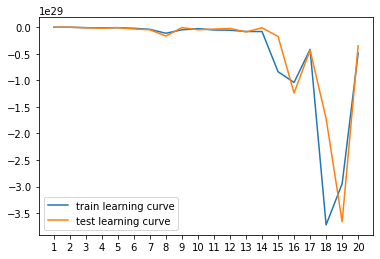

In [3]:
x_list = [] ### n_rois
train_y_list = [] ### accuracy
test_y_list = []

for i in range(1,21):
  ### K-means ####
  kmeans = KMeans(n_clusters=i, random_state=42).fit(train_input) ### feature engineering on train_split
  kmeans_train_input = kmeans.transform(train_input)
  kmeans_test_input = kmeans.transform(test_input)

  SGDReg = SGDRegressor()

  model = make_pipeline(PolynomialFeatures(2),SGDReg)
  model.fit(kmeans_train_input, train_output)
  
  log_predict_train = model.predict(kmeans_train_input)
  log_predict_output = model.predict(kmeans_test_input)
  
  test_accuracy = r2_score(test_output,log_predict_output)
  train_accuracy = r2_score(train_output,log_predict_train)

  x_list.append(i) 
  train_y_list.append(train_accuracy) 
  test_y_list.append(test_accuracy)

plt.xticks(x_list)
plt.plot(x_list,train_y_list,label='train learning curve')
plt.plot(x_list,test_y_list,label='test learning curve')
  
plt.legend()
plt.show()